In [1]:
import sys
import logging

import pandas as pd
import matplotlib.pyplot as plt
import cstrees.cstree as ct
import cstrees.scoring as sc
import cstrees.stage as st
import cstrees.learning as ctl
import networkx as nx
import numpy as np
import pp

%load_ext autoreload
%autoreload 2
#logging.basicConfig(stream=sys.stderr, level=logging.DEBUG)
logging.basicConfig(stream=sys.stderr, level=logging.ERROR)


In [3]:
from cstrees import csi_relation

ci = csi_relation.CI({1,2}, {3,4},{5})
print(ci)
dec = csi_relation.decomposition(ci)
for d in dec:
    print(d)

X1, X2 ⊥ X3, X4 | X5
X1 ⊥ X3 | X5
X1 ⊥ X4 | X5
X2 ⊥ X3 | X5
X2 ⊥ X4 | X5


In [182]:
wk = csi_relation.weak_union(ci)
for w in wk:
    print(w)

X1, X2 ⊥ X4 | X3, X5
X1, X2 ⊥ X3 | X4, X5
X2 ⊥ X3, X4 | X1, X5
X1 ⊥ X3, X4 | X2, X5


In [183]:
print("Original CI: ", ci)
pw = csi_relation.pairwise_cis(ci)
print("Pairwise CIs:")
for x in pw:
    print(x)

Original CI:  X1, X2 ⊥ X3, X4 | X5
Pairwise CIs:
X1 ⊥ X3 | X2, X4, X5
X1 ⊥ X4 | X2, X3, X5
X2 ⊥ X3 | X1, X4, X5
X2 ⊥ X4 | X1, X3, X5


In [184]:
c = csi_relation.Context({6:0})
csi = csi_relation.CSI(ci, c)

print("Original CSI: ", csi)
pw = csi_relation.pairwise_csis(csi)
print("Pairwise CSIs:")
for x in pw:
    print(x)

Original CSI:  X1, X2 ⊥ X3, X4 | X5, X6=0
Pairwise CSIs:
X1 ⊥ X3 | X2, X4, X5, X6=0
X1 ⊥ X4 | X2, X3, X5, X6=0
X2 ⊥ X3 | X1, X4, X5, X6=0
X2 ⊥ X4 | X1, X3, X5, X6=0


      a  b  c
0     2  2  2
1     1  0  1
2     1  0  0
3     1  0  0
4     0  0  0
...  .. .. ..
4996  1  0  0
4997  1  0  0
4998  0  0  0
4999  1  0  0
5000  1  0  0

[5001 rows x 3 columns]


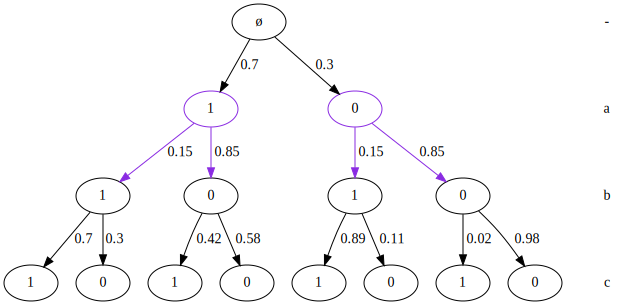

In [396]:
np.random.seed(6)
tree = ct.CStree([2] * 3, labels=["a", "b", "c"])

# V-structure
tree.update_stages({
    0: [st.Stage([{0, 1}])],
    1: [st.Stage([0, 0]), st.Stage([0, 1]), st.Stage([1, 0]), st.Stage([1, 1])]})

tree.sample_stage_parameters(alpha=1.0)

a = tree.plot()

# a.draw("testplot.png")
x = tree.sample(5000)
print(x)

true_cdags = tree.to_minimal_context_graphs()
for key, val in true_cdags.items():
    agraph = nx.nx_agraph.to_agraph(val)
    agraph.layout("dot")
    agraph.draw("testing/"+str(key) + "_true.png",
                args='-Glabel="'+str(key)+'"   ')
a


optimal order: ['b', 'a', 'c'], score -8222.118920345132
stages :{0: [<cstrees.stage.Stage object at 0x7febb944ac20>], 1: [<cstrees.stage.Stage object at 0x7febb94488e0>, <cstrees.stage.Stage object at 0x7febb9449f60>], 2: [], -1: [<cstrees.stage.Stage object at 0x7febbaa30e80>]}

Optimal CStree stagings per level:
level 0:
[]
level 1:
[0]
[1]
level 2:


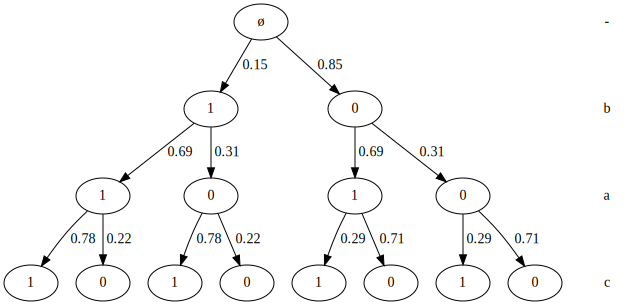

In [399]:
optord, score = ctl._find_optimal_order(
    x, strategy="posterior", max_cvars=2, alpha_tot=1.0, method="BDeu")
print("optimal order: {}, score {}".format(optord, score))

opttree = ctl._optimal_cstree_given_order(optord, x, max_cvars=2,
                             alpha_tot=1.0, method="BDeu")
print("stages :{}".format(opttree.stages))

print("\nOptimal CStree stagings per level:")
for key, val in opttree.stages.items():
    if key == -1:
        continue
    print("level {}:".format(key))
    for val2 in val:
        print(val2)
opttree.estimate_stage_parameters(x, alpha_tot=1.0, method="BDeu")
opttree.plot()


In [189]:
opt_cdags = opttree.to_minimal_context_graphs()
for key, val in opt_cdags.items():
    agraph = nx.nx_agraph.to_agraph(val)
    agraph.layout("dot")
    agraph.draw("testing/"+str(key) + "_opt.png",
                args='-Glabel="'+str(key)+'"   ')


In [190]:
tree = ctl.find_optimal_cstree(x, max_cvars=2, alpha_tot=1.0, method="BDeu")

tree.to_df()

,a,b,c
0,2,2,2
1,*,-,-
2,0,0,-
3,1,0,-
4,0,1,-
5,1,1,-


In [400]:
order = ["a", "b", "c"]
orderscore = sc.score_order(order, x, strategy="posterior", max_cvars=2, alpha_tot=1.0, method="BDeu")
nodescores = [sc._score_order_at_level(order, level, x, strategy="posterior", max_cvars=2, alpha_tot=1.0, method="BDeu") for level in range(len(order))]
print(orderscore)
print(nodescores)
print(np.sum(nodescores))
neig = ctl.get_relocation_neighborhood(order, 1, orderscore, nodescores, x, max_cvars=2, alpha_tot=1.0, method="BDeu")
print(order)
print("nodescores: ", nodescores)

print("neig: ", list(neig))

score at level 0 : -3116.1202505997753
score at level 1 : -2123.9198080480464
score at level 2 : -3033.305429574885
-8273.345488222707
[-3116.1202505997753, -2123.9198080480464, -3033.305429574885]
-8273.345488222707
['a', 'b', 'c']
nodescores:  [-3116.1202505997753, -2123.9198080480464, -3033.305429574885]
neig:  [0.4999999999999138, 0.4999999999999138, 8.631092375820474e-114]


In [456]:
orders, scores = ctl.gibbs_order_sampler(100000, x, max_cvars=2, alpha_tot=1.0, method="BDeu")

Calculating positional order scores for each variable: 100%|██████████| 3/3 [00:00<00:00, 1493.88it/s]


initial order: ['a', 'b', 'c']
initial score: -8273.345488222707


100%|██████████| 99999/99999 [00:24<00:00, 4079.03it/s]


In [25]:
p = 5
cards = [2] * p

t = ct.sample_cstree(cards, 2, 0.5, 1)
t.sample_stage_parameters(alpha=2)


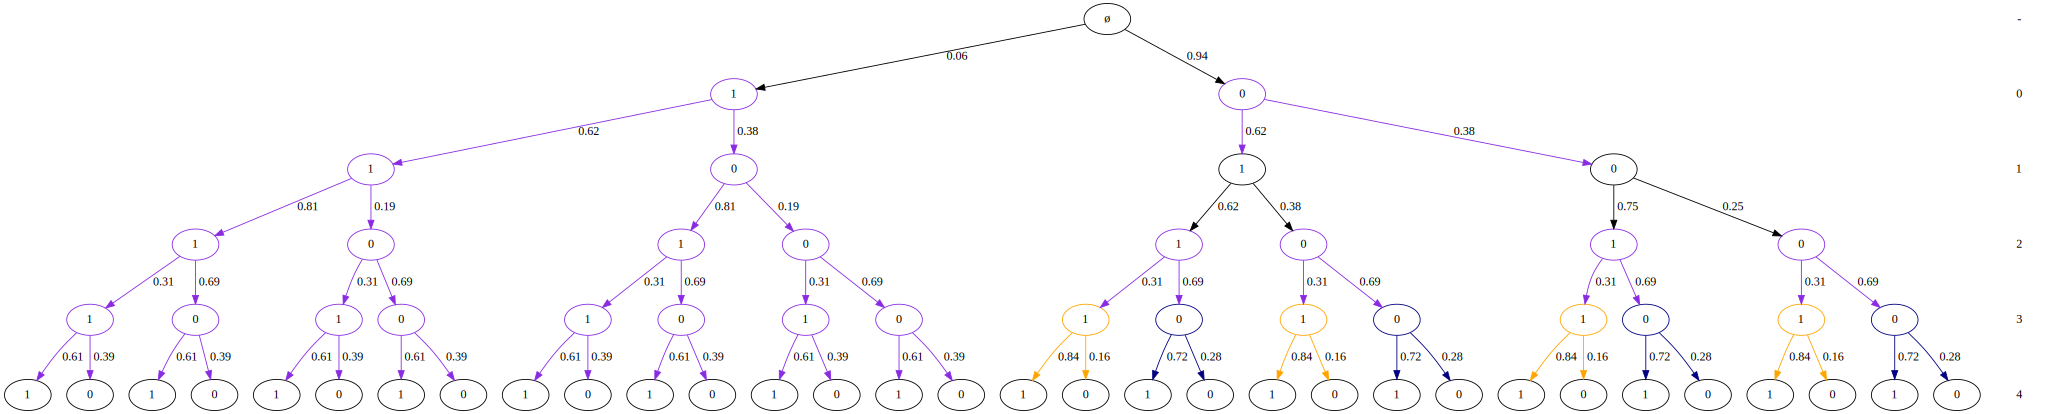

In [3]:
t.plot()

In [6]:
agraphs= t.to_minimal_context_agraphs()

In [ ]:
keys = list(agraphs.keys())
print(keys[0])
agraphs[keys[0]]

In [ ]:
print(keys[1])
agraphs[keys[1]]

In [4]:
x2 = t.sample(500)

In [50]:
score_table, context_scores, context_counts = sc.order_score_tables(x2, max_cvars=2, alpha_tot=1.0, method="BDeu")

Context score tables:   0%|          | 0/5 [00:00<?, ?it/s]

Order score tables: 100%|██████████| 5/5 [00:00<00:00, 47.50it/s]


In [52]:
pp(context_scores)

{
    'cards': {0: 2, 1: 2, 2: 2, 3: 2, 4: 2},
    'scores': {
        0: {
            '1=0': -39.11630953855279,
            '1=0,2=0': -10.99265420657177,
            '1=0,2=1': -30.842523574709443,
            '1=0,3=0': -33.74740937548981,
            '1=0,3=1': -7.216069172038738,
            '1=0,4=0': -13.915963619242982,
            '1=0,4=1': -27.913703146431416,
            '1=1': -77.47632717820227,
            '1=1,2=0': -19.82416605289377,
            '1=1,2=1': -59.91419975201417,
            '1=1,3=0': -55.643919093360466,
            '1=1,3=1': -25.079058062325473,
            '1=1,4=0': -28.010427955246367,
            '1=1,4=1': -52.63760692848499,
            '2=0': -28.136463619930588,
            '2=0,3=0': -23.194019945272,
            '2=0,3=1': -7.12262938668294,
            '2=0,4=0': -16.563555851308063,
            '2=0,4=1': -12.576357844983859,
            '2=1': -87.88315656166648,
            '2=1,3=0': -65.80640106094802,
            '2=1,3=1': -25.3554

In [45]:
orders2, scores2 = ctl.gibbs_order_sampler(2000, score_table)

initial order: [3, 4, 0, 1, 2]
initial score: -1373.8374863365693


Gibbs order sampler:   0%|          | 0/2000 [00:00<?, ?it/s]

Gibbs order sampler: 100%|██████████| 2000/2000 [00:00<00:00, 2971.36it/s]


In [46]:
context_scores

[-1373.8374863365693,
 -1373.8431619428843,
 -1373.8431619428843,
 -1373.8431619428843,
 -1373.8391037484846,
 -1373.8391037484846,
 -1373.8341145055276,
 -1373.8059776413634,
 -1373.83118655212,
 -1373.83118655212,
 -1373.83118655212,
 -1373.8679360199612,
 -1373.8679360199612,
 -1373.8679360199612,
 -1373.8059776413636,
 -1373.8341145055279,
 -1373.8391037484848,
 -1373.8391037484848,
 -1373.8321954439243,
 -1373.8321954439243,
 -1373.8321954439243,
 -1373.8488217964805,
 -1373.8963811140027,
 -1373.8338741366751,
 -1373.8963811140027,
 -1373.8234082063536,
 -1373.8162848958627,
 -1373.8082740877076,
 -1373.8020938926497,
 -1373.8020938926497,
 -1373.8489887523465,
 -1373.8489887523465,
 -1373.8341145055279,
 -1373.849633359513,
 -1373.8341145055279,
 -1373.8391037484848,
 -1373.8341145055279,
 -1373.8391037484848,
 -1373.8391037484848,
 -1373.8391037484848,
 -1373.8321954439243,
 -1373.9052919536616,
 -1373.8431619428848,
 -1373.8368621584355,
 -1373.8368621584355,
 -1373.8368621584

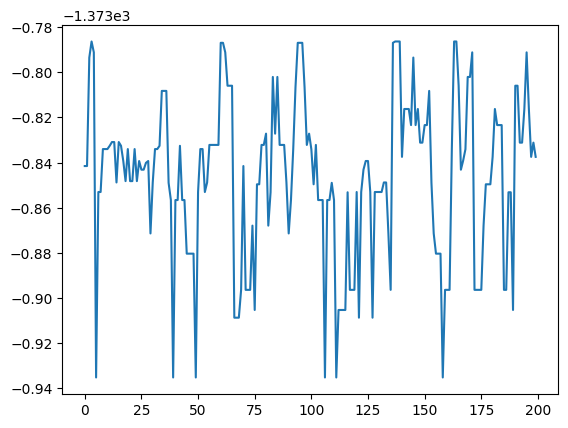

In [36]:
plt.plot(scores2[:200])

In [37]:
# Get the individual var locations on the order
var_positions = {var: [x.index(var) for x in orders2] for var in orders2[0]}
var_positions["iteration"] = list(range(len(orders2))) 
plotdf = pd.DataFrame(var_positions)

<AxesSubplot: xlabel='iteration'>

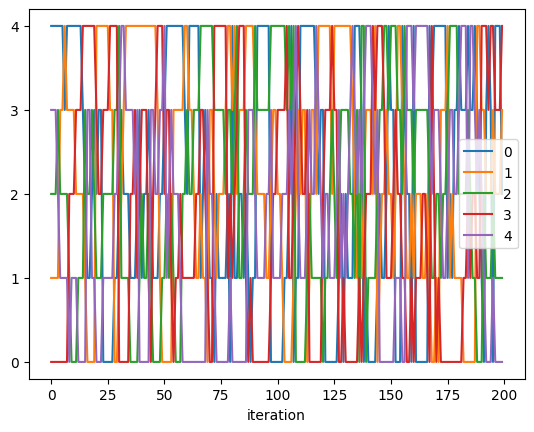

In [38]:
plotdf[:200].plot(x = "iteration", y = range(p), yticks=range(len(orders2[0])))

In [32]:
max(scores2)

-1373.7863845893187

In [33]:
maxi = scores2.index(max(scores2))

In [34]:
maporder = orders2[maxi]

In [44]:
context_scores

[-1373.8020938926497,
 -1373.8020938926497,
 -1373.8020938926497,
 -1373.8066035766662,
 -1373.8321954439243,
 -1373.8321954439243,
 -1373.8391037484848,
 -1373.8321954439243,
 -1373.8321954439243,
 -1373.8321954439243,
 -1373.8321954439243,
 -1373.8340315770088,
 -1373.8340315770088,
 -1373.8340315770088,
 -1373.8488217964805,
 -1373.8482271088212,
 -1373.880351899138,
 -1373.880351899138,
 -1373.8482271088214,
 -1373.8488217964807,
 -1373.8496333595133,
 -1373.839103748485,
 -1373.839103748485,
 -1373.8496333595133,
 -1373.8496333595133,
 -1373.8496333595133,
 -1373.8530482046485,
 -1373.8530482046485,
 -1373.849050634863,
 -1373.849050634863,
 -1373.8162848958627,
 -1373.7869792769784,
 -1373.7912056851462,
 -1373.8059776413638,
 -1373.8059776413638,
 -1373.8679360199615,
 -1373.8679360199615,
 -1373.9052919536614,
 -1373.8059776413636,
 -1373.8391037484848,
 -1373.849633359513,
 -1373.849633359513,
 -1373.849633359513,
 -1373.8391037484848,
 -1373.8059776413636,
 -1373.867936019961

In [53]:
opttree = ctl._optimal_cstree_given_order(maporder, context_scores,
                                          max_cvars=2,
                                          alpha_tot=1, method="BDeu")

context_scores:  {'cards': {0: 2, 1: 2, 2: 2, 3: 2, 4: 2}, 'scores': {0: {'None': -114.04909507448154, '1=0': -39.11630953855279, '1=1': -77.47632717820227, '2=0': -28.136463619930588, '2=1': -87.88315656166648, '3=0': -86.0547834064567, '3=1': -30.640348619555816, '4=0': -39.053731249686074, '4=1': -77.55026773393485, '1=0,2=0': -10.99265420657177, '1=0,2=1': -30.842523574709443, '1=1,2=0': -19.82416605289377, '1=1,2=1': -59.91419975201417, '1=0,3=0': -33.74740937548981, '1=0,3=1': -7.216069172038738, '1=1,3=0': -55.643919093360466, '1=1,3=1': -25.079058062325473, '1=0,4=0': -13.915963619242982, '1=0,4=1': -27.913703146431416, '1=1,4=0': -28.010427955246367, '1=1,4=1': -52.63760692848499, '2=0,3=0': -23.194019945272, '2=0,3=1': -7.12262938668294, '2=1,3=0': -65.80640106094802, '2=1,3=1': -25.35546284259651, '2=0,4=0': -16.563555851308063, '2=0,4=1': -12.576357844983859, '2=1,4=0': -25.35546284259651, '2=1,4=1': -65.80640106094802, '3=0,4=0': -32.5720203476059, '3=0,4=1': -56.786658189

AttributeError: 'list' object has no attribute 'context'

In [523]:
s2 = sc.score_order(range(len(score_table)), x2, max_cvars=2, alpha_tot=1.0, method="BDeu", strategy="posterior")

score at level 0 : -3370.339615239277
score at level 1 : -3336.7562984763604
score at level 2 : -3396.2725918635624
score at level 3 : -1333.7035970800987
score at level 4 : -3412.105181799819


In [515]:
s2

-14849.177284459118

In [ ]:
orders2